# **1.Import Required Libraries**

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

#
from pathlib import Path

# For data visualization
import matplotlib.pyplot as plt

# Set default font size for plots
plt.rcParams['font.size'] = 10

# For enhanced data visualization
import seaborn as sns

# XGBoost
import xgboost as xgb

from xgboost import XGBClassifier


# For model & metrics
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, RandomizedSearchCV # For hyperparameter tuning using randomized search
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay,roc_auc_score, \
    precision_score, recall_score, f1_score, average_precision_score,roc_curve

# Distributions for RandomizedSearchCV
from scipy.stats import uniform, randint

# SHAP for model explainability
import shap

from IPython.display import display, IFrame
import ipywidgets as widgets

# **2.Data Cleaning**

### **2.1 Data Overview**

In [2]:
# 1. Load data
base_path = Path("/Users/suzychen/Desktop/SSP/data from tippco")
customer_df = pd.read_excel(base_path / "customer_dimensions.xlsx")
payments_df = pd.read_excel(base_path / "payments_data.xlsx")
login_df = pd.read_excel(base_path / "login_data.xlsx")

# 2. Print original shape(rows, columns)
print("Original shapes:")
print("customer_df:", customer_df.shape)
print("payments_df:", payments_df.shape)
print("login_df:", login_df.shape)

# 3. Remove irrelevant fraud types
drop_ids = customer_df.loc[customer_df["fraud_type"].isin(["Bonus Hunters", "Hacked Account"]), "customer_id"]

# 4. Filter data
cus_df = customer_df[~customer_df["customer_id"].isin(drop_ids)].copy()
pay_df = payments_df[~payments_df["customer_id"].isin(drop_ids)].copy()
log_df = login_df[~login_df["customer_id"].isin(drop_ids)].copy()

# 5. Print updated shape
print("\nFiltered shapes:")
print("cus:", cus_df.shape)
print("pay:", pay_df.shape)
print("log:", log_df.shape)

Original shapes:
customer_df: (2375, 13)
payments_df: (31278, 7)
login_df: (738753, 7)

Filtered shapes:
cus: (2197, 13)
pay: (30867, 7)
log: (721115, 7)


In [3]:
# 6.Preview each dataset
display(cus_df.head())
display(pay_df.head())
display(log_df.head())

,customer_id,registrationdate,registration_ip_address,registration_channel,birthcountry,birthcity,nationality,address_city,address_region,address_country_code,age,is_fraud,fraud_type
0,nDi7mxux9NJNUgBNW4O0+A==,2021-03-06,60.167.89.150,ANDROID_NAT_RB,V6pEZeg173waZxj6d0PanQ==,pJTxU0MdTGp3HAqL2pMRuw==,7W3tgFUbHxuY4sLsdEj35Q==,J8fs+C+skHwy1Zwr45aMTw==,XlBpsJAQ6pqWt86o6aMUzg==,3nSZuigl+nxEHdk9bIB7sw==,33,N,NaN
1,ymEV56a2MF4wLTqAwFbsmA==,2021-01-28,197.219.155.151,DESKTOP_WEB_RETH,V6pEZeg173waZxj6d0PanQ==,84VZToXs2wKtI8/6qUjWRg==,7W3tgFUbHxuY4sLsdEj35Q==,8duHRLeB9XtSGIBlW4mdYA==,DbIfeDLAth9TGp7RdM0tpg==,3nSZuigl+nxEHdk9bIB7sw==,3,N,NaN
2,PNpaUMNgfpnGvhQVTjRvBw==,2022-11-26,63.115.-11.95,IOS_NAT_RETH,V6pEZeg173waZxj6d0PanQ==,SKAq+FnpGABE6bOVu5GIMg==,7W3tgFUbHxuY4sLsdEj35Q==,VxxIYg2Tx4PTrhUNcA+vxw==,1BAbIYevLXXWMBpCtunoyQ==,3nSZuigl+nxEHdk9bIB7sw==,10,N,NaN
4,uaoTMAPjIssh+igWTh7/aQ==,2021-02-08,72.190.35.232,IOS_NAT_RB,V6pEZeg173waZxj6d0PanQ==,EQZwxkKpMhMTCx6PKOgRWg==,OSbBBJHivQYeUwOk8EZqRw==,5HdAgiTK/Di6+kfqJ4QWzA==,jbMqJCTexCbPuCyxmoJxig==,3nSZuigl+nxEHdk9bIB7sw==,3,N,NaN
5,EhEr1XNbFXn83fZgcs1ryw==,2023-05-12,59.227.210.33,DESKTOP_WEB_RETH,V6pEZeg173waZxj6d0PanQ==,XrQRGa3pDAq48grm0mrqlw==,7W3tgFUbHxuY4sLsdEj35Q==,mAD9Cad55jVnvufLjTbZtA==,lHhoSVsHn4E6m1IRLvKpwQ==,3nSZuigl+nxEHdk9bIB7sw==,13,Y,Credit Card Fraud


,customer_id,paymenttransaction_id,transactiondate,transactiontype,paymentdatatype_name,paymentstatus_name,amount_eur
0,SsRXK4bpXIok99gPdyWJmQ==,LtrIlRAtKAkoLZuzfZxraw==,2023-03-03 18:32:23,PAYIN,Cash,Executed,15.0
1,0VsNpHSoHw0DCrnD+J0cIQ==,l5j3Qyw91CMEoDPfvueslA==,2023-02-16 20:04:00,PAYIN,PayPal,Requested,100.0
2,qLZkiIFqzQmIUZjMA+zvnA==,wVoYvQwwRmsc+P1O5W8/vQ==,2021-12-15 17:03:34,PAYIN,CASH2DIGITAL,Executed,35.0
3,CVLOCRkRjw8wYN1LoFOt7g==,kwYFMHJ6IADy2u5ZyYwh6g==,2024-01-04 22:28:00,PAYIN,MASTERCARD_KALIXA,Failed,60.0
4,UWpWTSgrvW4KLm/GcebR8w==,/94knwQrdMyBjL449g5ZMA==,2022-05-09 16:17:57,PAYIN,VISA_KALIXA,Executed,10.0


,login_id,customer_id,login_date,login_ip_address,login_channel,login_type,producttype_id
0,gyzx7gkGU8jKtVLhGOjCOw==,IgmIxWMXwZLjg4VjZN+I5g==,2025-03-03,156.-16.110.164,IOS_NAT_RETH,SUCCESS,33
1,XnOms1jGAc/AlHJAGqPBXg==,E2dz7sMZxbgyPwqOIdHXvA==,2025-03-03,68.96.22.226,IOS_NAT_RETH,SUCCESS,33
2,K17H9Bwg43Yf3KFjfyvacw==,Tp/AMPvNzRSK6RDGp5EhcQ==,2025-03-03,89.22.156.54,IOS_NAT_RETH,SUCCESS,33
3,XAIHKalnfzYu0FPEym20wg==,ZACJOWdMcE3kVUt9l8bKWQ==,2025-03-03,42.123.59.82,ANDROID_NAT_RETH,SUCCESS,33
4,VZmRiVG8ZafJdHH27NVEwQ==,k66syfoQoDwIjArHnvp+gw==,2025-03-03,75.71.178.34,MOBILE_WEB_RETH,SUCCESS,33


##### Fields such as birth location and address details in cus_df that are not useful for fraud detection,
##### so we decide to remove them:

In [4]:
# 7.Remove irrelevant columns
cols_to_drop = [
    "birthcountry", "birthcity", "address_city",
    "address_region", "address_country_code"
]

cus_df = cus_df.drop(columns=cols_to_drop)

### **2.2 Missing Value & Data Type**

##### Although XGBoost can handle missing values by learning optimal split directions during training,  
##### we conduct a basic missing value analysis to identify potential data quality issues and reduce the risk of systematic bias.

In [5]:
# Check misssing value and data tpye for each dataframe
print("Customer DataFrame - dtypes:")
print(cus_df.info())

print("\nPayments DataFrame - dtypes:")
print(pay_df.info())

print("\nLogin DataFrame - dtypes:")
print(log_df.info())

Customer DataFrame - dtypes:
<class 'pandas.core.frame.DataFrame'>
Index: 2197 entries, 0 to 2374
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              2197 non-null   object        
 1   registrationdate         2197 non-null   datetime64[ns]
 2   registration_ip_address  1733 non-null   object        
 3   registration_channel     1733 non-null   object        
 4   nationality              2197 non-null   object        
 5   age                      2197 non-null   int64         
 6   is_fraud                 2197 non-null   object        
 7   fraud_type               197 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 154.5+ KB
None

Payments DataFrame - dtypes:
<class 'pandas.core.frame.DataFrame'>
Index: 30867 entries, 0 to 31277
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  

##### The **registration_ip_address** and **registration_channel** columns have ～ 20% missing values, 
##### while the **login_ip_address** column has a very small proportion of missing values (< 1%). 
##### Considering the relatively low proportion of missing data, we decide to retain these samples.

In [6]:
# Convert 'is_fraud' to binary integer
cus_df["is_fraud"] = cus_df["is_fraud"].map({"Y": 1, "N": 0})

In [7]:
# Check descriptive statistics for the 'age' column
cus_df['age'].describe()

count    2197.000000
mean       12.998635
std        12.249029
min        -2.000000
25%         3.000000
50%        10.000000
75%        19.000000
max        65.000000
Name: age, dtype: float64

##### The average age is only 12 years, with over 75% of users under 19, and even some negative values.
##### This indicates that the age data is unreliable or invalid.

In [8]:
# Drop the "age" column
cus_df = cus_df.drop(columns='age')

## **3. Exploratory data analysis (EDA)** 

#### **3.1 EDA of customer dataset `cus_df`**

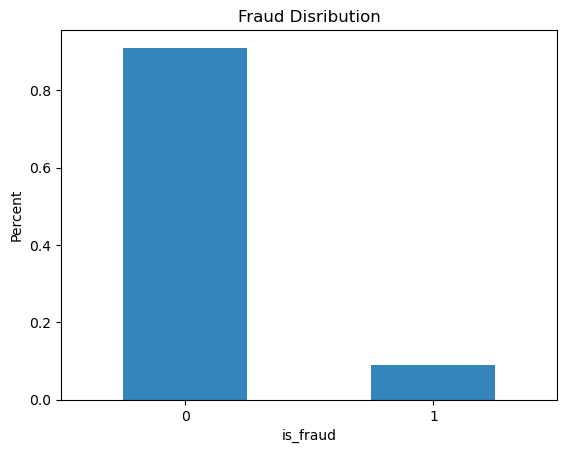

In [9]:
# Check the distribution of target variable "is_fraud"
cus_df['is_fraud'].value_counts(normalize = True).plot(kind='bar', alpha = 0.9, rot=0)
plt.title('Fraud Disribution')
plt.ylabel('Percent')
plt.show()

##### The target variable is_fraud is **highly imbalanced**,which is a common characteristic in fraud detection tasks.
##### **To address this issue, we follow the method proposed by Priscilla and Prabha (2020),**
##### **tuning XGBoost’s parameters to emphasize the minority class without resampling**
##### Details will be discussed in the model training section.

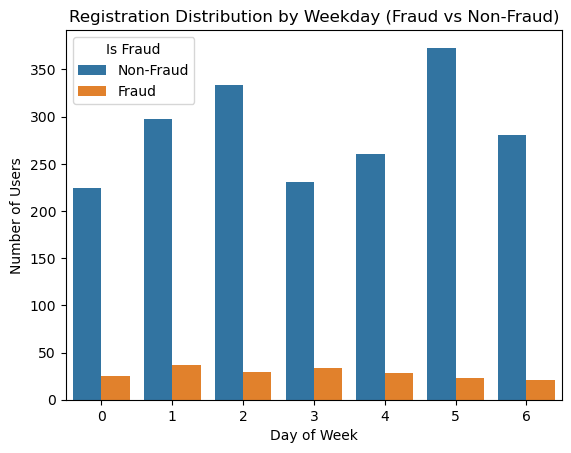

In [10]:
# Extract registration day of week (0=Monday, 6=Sunday)
cus_df["reg_dayofweek"] = cus_df["registrationdate"].dt.dayofweek

sns.countplot(data=cus_df, x="reg_dayofweek", hue="is_fraud", order=range(7))
plt.title("Registration Distribution by Weekday (Fraud vs Non-Fraud)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Users")
plt.xticks(ticks=range(7))
plt.legend(title="Is Fraud", labels=["Non-Fraud", "Fraud"])
plt.show()

##### Fraudulent registrations appear evenly distributed across weekdays, showing no significant preference or concentration. 
##### Therefore, this would not be a useful detection signal.

In [11]:
# Count the number of unique values in each column with object (categorical/text) data type
cus_df.select_dtypes(include='object').nunique()

customer_id                2197
registration_ip_address    1627
registration_channel         13
nationality                  61
fraud_type                    2
dtype: int64

##### Let’s begin by examining the relationship between fraud and ip:

In [12]:
# Add the shared IP flag to cus_df
cus_df["res_ip_shared"] = cus_df["registration_ip_address"].map(
    cus_df["registration_ip_address"].value_counts().gt(1).astype(int)
).fillna(0).astype(int)


# Create summary table
fraud_ratio_table = (
    cus_df[["res_ip_shared", "is_fraud"]]
    .groupby("res_ip_shared")["is_fraud"]
    .value_counts(normalize=True)
    .unstack()
)

fraud_ratio_table

is_fraud,0,1
res_ip_shared,,
0,0.913735,0.086265
1,0.852459,0.147541


##### Users with shared registration IP addresses show a higher fraud rate (14.75%) compared to those with unique IPs (8.63%), 
##### suggesting that IP sharing might be an early indicator of fraud risk.

##### Then we plot the relationship between `registration_channel` the target variable `is_fraud`:

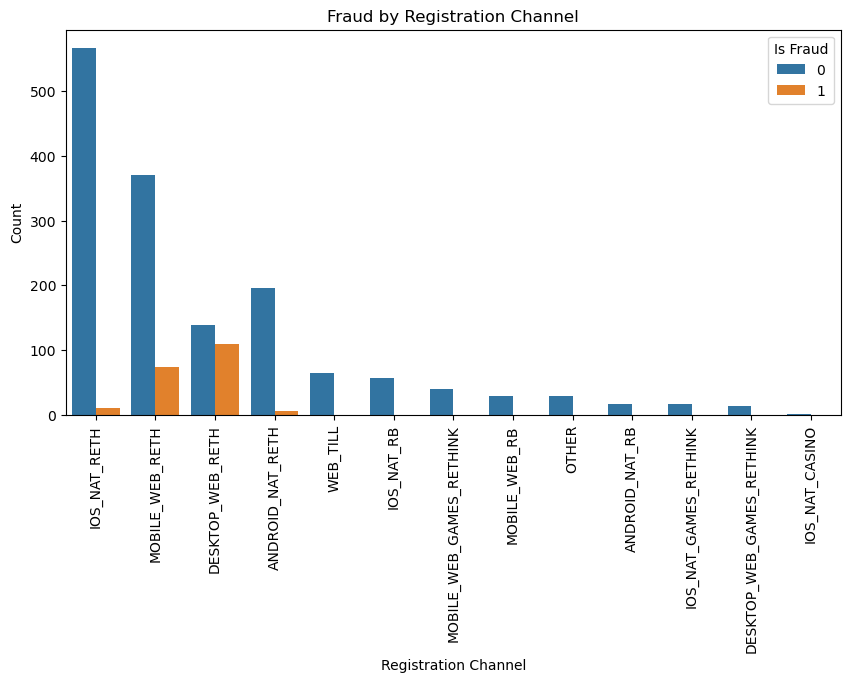

In [13]:
plt.figure(figsize=(10, 5))
sns.countplot(
    data=cus_df,
    x='registration_channel',
    hue='is_fraud',
    order=cus_df['registration_channel'].value_counts().index
)

plt.title('Fraud by Registration Channel')
plt.xticks(rotation=90)
plt.xlabel('Registration Channel')
plt.ylabel('Count')
plt.legend(title='Is Fraud')
plt.show()

##### Most fraud cases occur in channels like **DESKTOP_WEB_RETH** and **MOBILE_WEB_RETH**.
##### This suggests that the registration channel may serve as an early indicator of potential fraud risk.

##### Then check the relationship between `nationality` the target variable：

In [14]:
# Count the number of customers per nationality
nat_count = cus_df['nationality'].value_counts()

# Calculate the fraud rate (mean of is_fraud) for each nationality
nat_fraud = cus_df.groupby("nationality")["is_fraud"].mean()

# Combine count and fraud rate into a single summary table, sorted by fraud rate
nat_stats = pd.DataFrame({
    "count": nat_count,
    "fraud_rate": nat_fraud
}).sort_values("fraud_rate", ascending=False)

# Display the top 5 nationalities with the highest fraud rate
display(nat_stats[nat_stats["fraud_rate"] >= 0].head(5))

,count,fraud_rate
nationality,,
Ux8pDlPL74vuqBwen/xRkA==,6,1.000000
VFole8+8Uy9+7X73eeaTsQ==,11,0.727273
7W3tgFUbHxuY4sLsdEj35Q==,1522,0.118265
Ubu5LqPH/H15kjLSjLterQ==,113,0.026549
/RkNivdPzD8aR2SNy/C3Gg==,4,0.000000


##### By examining the proportion of fraud cases across different nationalities, 
##### we observe that users from certain nationalities may indicate potential risk signals.
##### However, since nationality is a high-cardinality variable and has been encoded in the dataset, 
##### it is difficult to derive any meaningful interpretation from it.

#### **3.2 EDA of payment dataset `pay_df`**

In [15]:
# Count unique values in each categorical (object) column 
pay_df.select_dtypes(include='object').nunique()

customer_id               2166
paymenttransaction_id    30867
transactiontype              3
paymentdatatype_name        21
paymentstatus_name           7
dtype: int64

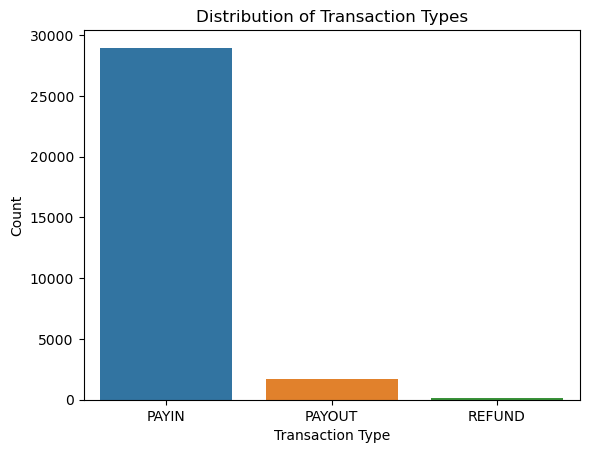

In [16]:
# Plot transaction type distribution
sns.countplot(data=pay_df, x="transactiontype", order=pay_df["transactiontype"].value_counts().index)
plt.title("Distribution of Transaction Types")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

In [17]:
# Display descriptive statistics for the payment amount (amount_eur)
pay_df["amount_eur"].describe()

count    30867.000000
mean        95.294193
std        483.756401
min          0.020000
25%         10.000000
50%         20.000000
75%         50.000000
max      31000.000000
Name: amount_eur, dtype: float64

##### The large gap between the max and 75th percentile suggests outliers. Let's visualize the payment amount distribution：

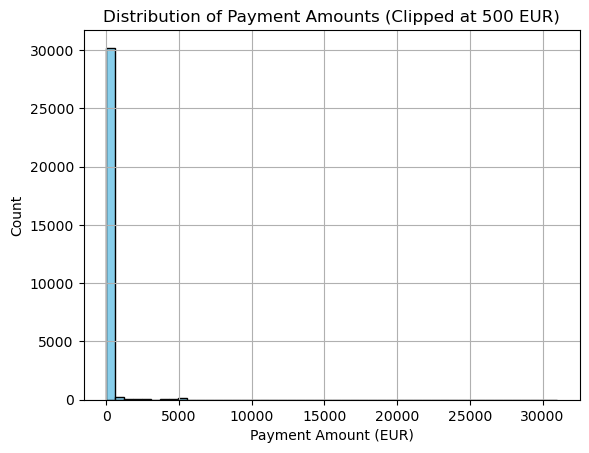

In [18]:
pay_df["amount_eur"].hist(bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Payment Amounts (Clipped at 500 EUR)")
plt.xlabel("Payment Amount (EUR)")
plt.ylabel("Count")
plt.show()

##### Perform logarithmic transformation on the amount:

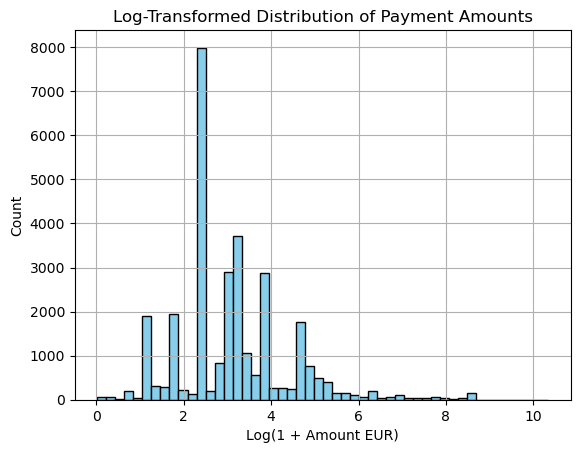

In [19]:
# Apply log transformation to payment amount
pay_df["log_amount_eur"] = np.log1p(pay_df["amount_eur"])

# Visualize
pay_df["log_amount_eur"].hist(bins=50, color='skyblue', edgecolor='black')
plt.title("Log-Transformed Distribution of Payment Amounts")
plt.xlabel("Log(1 + Amount EUR)")
plt.ylabel("Count")
plt.show()

##### Next, we exclude these outliers to better examine the overall distribution of transaction amounts：

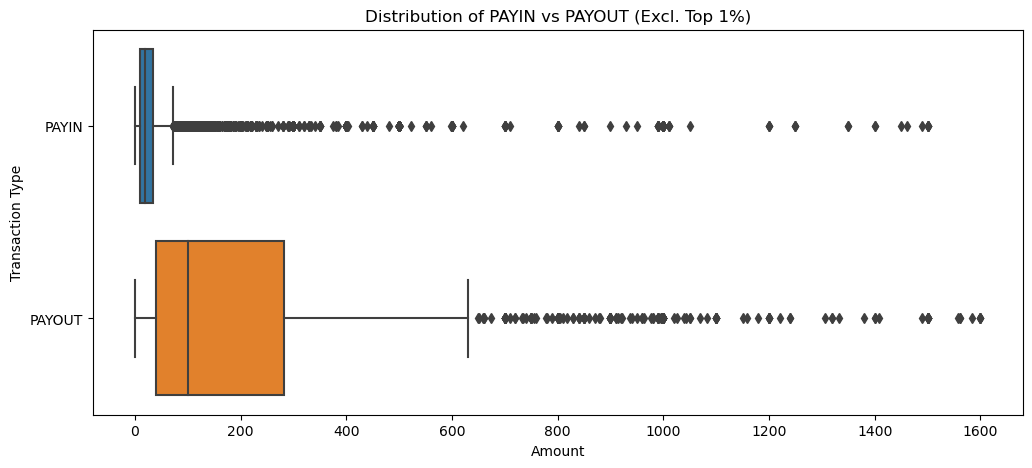

In [20]:
# Filter PAYIN and PAYOUT
payin_payout_df=pay_df[pay_df["transactiontype"].isin(["PAYIN", "PAYOUT"])].copy()

# Boxplot (exclude top 1%)
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=payin_payout_df[payin_payout_df["amount_eur"] <= payin_payout_df["amount_eur"].quantile(0.99)],
    y="transactiontype", x="amount_eur"
)
plt.title("Distribution of PAYIN vs PAYOUT (Excl. Top 1%)")
plt.xlabel("Amount")
plt.ylabel("Transaction Type")
plt.show()

##### The boxplot shows that most PAYIN transactions are concentrated below €50, while PAYOUT transactions are mostly below €300

##### Next, we examine the distribution of transaction activity by hour of the day:

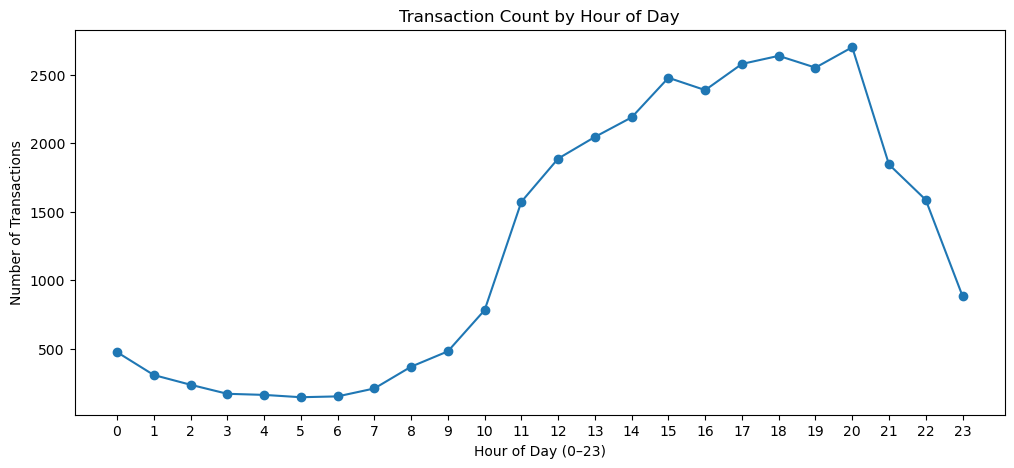

In [21]:
# Extract the hour from each transaction timestamp and count occurrences
hourly_counts = pay_df['transactiondate'].dt.hour.value_counts().sort_index()

# Plot line chart to show hourly transaction trends
plt.figure(figsize=(12, 5))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o')
plt.title('Transaction Count by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Number of Transactions')
plt.xticks(range(0, 24))
plt.show()

##### Transaction activity is low during nighttime and increases during the day, exhibiting a clear diurnal pattern.

#####  Now analyze the time gap (in days) between each PAYIN and the next subsequent PAYOUT:

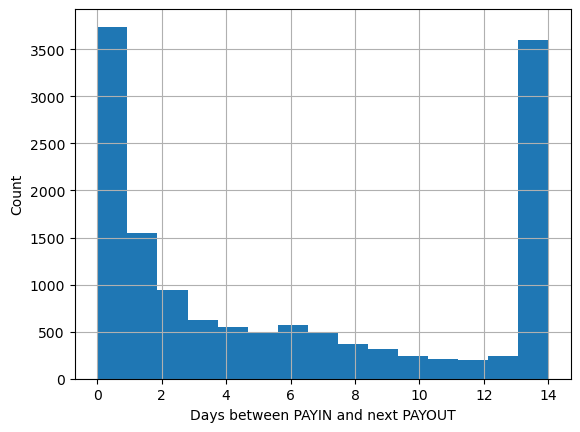

In [22]:
# Separate PAYIN and PAYOUT transactions
payins = payin_payout_df[payin_payout_df['transactiontype'] == 'PAYIN']
payouts = payin_payout_df[payin_payout_df['transactiontype'] == 'PAYOUT']

# For each PAYIN, find subsequent PAYOUTs by the same customer
merged = payins.merge(
    payouts, 
    on='customer_id', 
    suffixes=('_payin', '_payout')
)

# Keep only rows where the PAYOUT happened after the PAYIN
merged = merged[
    merged['transactiondate_payout'] > merged['transactiondate_payin']
]

# For each PAYIN, get the earliest subsequent PAYOUT (minimum payout date)
first_payout_after_payin = merged.groupby('paymenttransaction_id_payin')[
    'transactiondate_payout'
].min().reset_index()

# Merge back to original PAYINs to calculate the gap in days
result = payins.merge(first_payout_after_payin, left_on='paymenttransaction_id', right_on='paymenttransaction_id_payin', how='left')
result['gap_days'] = (result['transactiondate_payout'] - result['transactiondate']).dt.days

# Visualize the result
result['gap_days'].dropna().clip(0, 14).hist(bins=15)
plt.xlabel('Days between PAYIN and next PAYOUT')
plt.ylabel('Count')
plt.show()

#####  The histogram shows that most PAYOUTs occur either on the same day or one day after a PAYIN, with another noticeable spike at 14 days

#### **3.3 EDA of login dataset `login_df`**

In [23]:
# Count unique values in each categorical (object) column 
log_df.select_dtypes(include='object').nunique()

login_id            721115
customer_id           2195
login_ip_address    117221
login_channel           15
login_type               2
dtype: int64

##### Check the distribution of login channels:

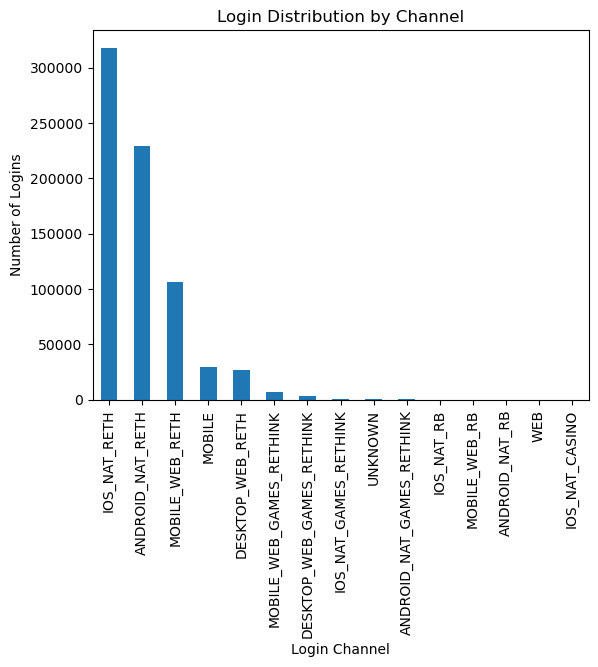

In [24]:
# Count number of logins by channel
channel_counts = log_df['login_channel'].value_counts()

# Plot
channel_counts.plot(kind='bar')
plt.title('Login Distribution by Channel')
plt.xlabel('Login Channel')
plt.ylabel('Number of Logins')
plt.show()

##### The majority of user logins occurred in iOS_NAT_RETH, ANDROID_NAT_RETH, and MOBILE_WEB_RETH

##### Now we look at the average daily login frequency per customer:

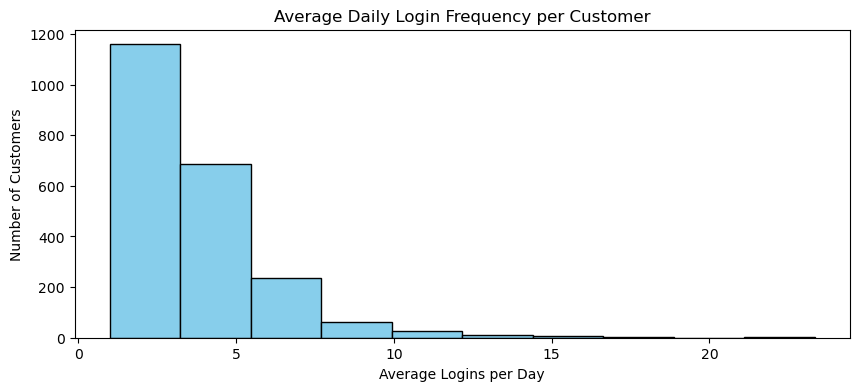

In [25]:
# Calculate and plot average daily login frequency per customer
daily_avg = (
    log_df.groupby(['customer_id', pd.Grouper(key='login_date', freq='D')])
    .size()
    .groupby('customer_id')
    .mean()
)

daily_avg.plot(kind='hist', figsize=(10, 4), color='skyblue', edgecolor='black')
plt.title('Average Daily Login Frequency per Customer')
plt.xlabel('Average Logins per Day')
plt.ylabel('Number of Customers')
plt.show()

##### The distribution is right-skewed, with most customers having an average daily login frequency <5.

##### Next, we merge the customer registration date into the payments dataset to calculate the time gap (in days) 
##### between each customer's first payment and their registration date.

In [26]:
# Get first transaction per customer
first_tx = pay_df.sort_values(['customer_id', 'transactiondate']).groupby('customer_id').first().reset_index()

# Rename and merge into customer dataset
first_tx = first_tx[['customer_id', 'transactiondate', 'amount_eur']].rename(
    columns={'transactiondate': 'first_tx_date', 'amount_eur': 'first_tx_amount'}
)

cus_df = cus_df.merge(first_tx, on='customer_id', how='left')

# Calculate time gap in days
cus_df['days_to_first_tx'] = (cus_df['first_tx_date'] - cus_df['registrationdate']).dt.days

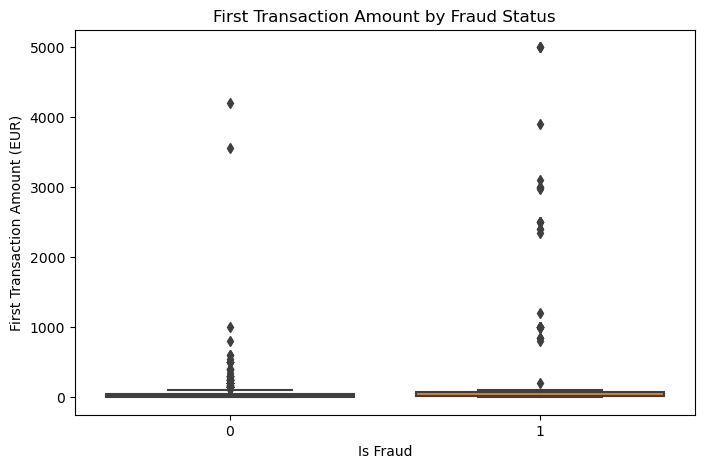

In [27]:
# Visualize first_tx_amount vs is_fraud
plt.figure(figsize=(8, 5))
sns.boxplot(data=cus_df, x="is_fraud", y="first_tx_amount")
plt.title("First Transaction Amount by Fraud Status")
plt.xlabel("Is Fraud")
plt.ylabel("First Transaction Amount (EUR)")
plt.show()

##### Fraudulent users tend to have higher first transaction amounts, with more extreme outliers compared to non-fraudulent users.

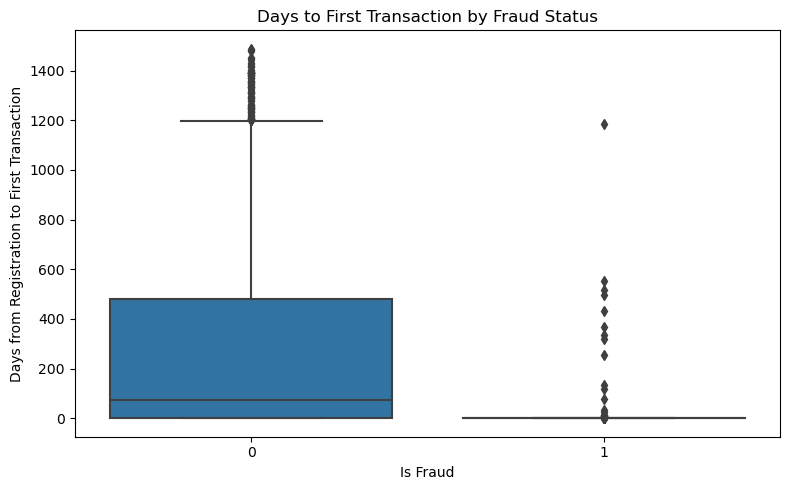

In [28]:
# Visualize days_to_first_tx vs is_fraud
plt.figure(figsize=(8, 5))
sns.boxplot(data=cus_df, x="is_fraud", y="days_to_first_tx")
plt.title("Days to First Transaction by Fraud Status")
plt.xlabel("Is Fraud")
plt.ylabel("Days from Registration to First Transaction")
plt.tight_layout()
plt.show()

##### The boxplot above indicates that fraudulent users tend to transact much sooner after registration compared to legitimate users.

## **4. Feature Engineering** 

#### **4.1 Feature from customer dataset + payment dataset** 

##### Based on the above data exploration, we select the following features for modeling:
##### **1.'res_ip_shared' 2.'registration_channel' 3.'first_tx_amount' 4.'days_to_first_tx'**

##### Firstly deal with the registration channel variable
##### It has 13 unique categories with the top 4 most frequent channels represent the main registration sources.  
##### To simplify the feature space, we retain only these top 4 channels and group all others to "others".

In [29]:
# Count the number of users per registration channel
channel_counts = cus_df["registration_channel"].value_counts()

print(channel_counts)

registration_channel
IOS_NAT_RETH                 577
MOBILE_WEB_RETH              443
DESKTOP_WEB_RETH             247
ANDROID_NAT_RETH             200
WEB_TILL                      64
IOS_NAT_RB                    57
MOBILE_WEB_GAMES_RETHINK      40
MOBILE_WEB_RB                 29
OTHER                         28
ANDROID_NAT_RB                17
IOS_NAT_GAMES_RETHINK         16
DESKTOP_WEB_GAMES_RETHINK     14
IOS_NAT_CASINO                 1
Name: count, dtype: int64


In [30]:
# Get the top 4 most frequent registration channels
top_channels = cus_df['registration_channel'].value_counts().nlargest(4).index

# Group the remaining channels into 'others'
cus_df['reg_channel'] = cus_df['registration_channel'].apply(
    lambda x: x if x in top_channels else 'others')

##### Based on initial EDA, we further analyzed the distribution of 7-day PAYIN counts:

In [31]:
# Merge registration date from cus_df into pay_df
pay_df = pay_df.merge(
    cus_df[['customer_id', 'registrationdate']],
    on='customer_id'
)

# Filter PAYIN transactions within 7 days after registration
payin_7d = pay_df[
    (pay_df["transactiontype"] == "PAYIN") &
    ((pay_df["transactiondate"] - pay_df["registrationdate"]).dt.days <= 7)]

# Count PAYIN transactions within 7 days per customer and assign to cus_df
cus_df["payin_count_within_7d"] = (
    cus_df["customer_id"].map(
        payin_7d.groupby("customer_id")["transactiontype"].count()
    ).fillna(0).astype(int)
)

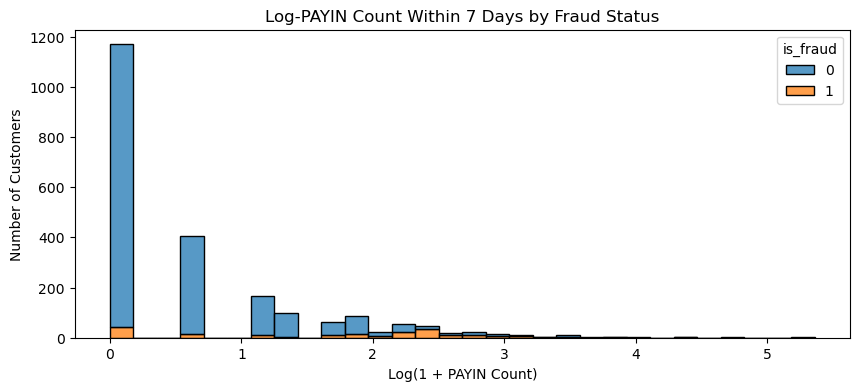

In [32]:
# Visualize
plt.figure(figsize=(10, 4))
sns.histplot(data=cus_df, x=np.log1p(cus_df["payin_count_within_7d"]), hue="is_fraud", multiple="stack", bins=30)
plt.title('Log-PAYIN Count Within 7 Days by Fraud Status')
plt.xlabel('Log(1 + PAYIN Count)')
plt.ylabel('Number of Customers')
plt.show()

##### A noticeable increase in the proportion of fraudsters when the log value exceeds 2 (i.e., more than 6–7 PAYINs) 
##### suggests that high-frequency PAYIN activity within 7 days of registration may be a fraud indicator.
##### Besides the # of PAYIN, we also think about amount in 7 days:

In [33]:
# Calculate total PAYIN amount per customer within 7 days and assign to cus_df
cus_df["payin_amount_within_7d"] = (
    cus_df["customer_id"].map(
        payin_7d.groupby("customer_id")["amount_eur"].sum()
    ).fillna(0)
)

##### We now explore payment density as a new feature.
##### This helps capture suspicious patterns like frequent top-ups in a short period, 
##### which total counts alone may miss due to extreme values.

In [34]:
# Count total PAYIN transactions per customer
payin_counts = pay_df[pay_df["transactiontype"] == "PAYIN"].groupby("customer_id").size()

# Compute active days (from registration to last transaction)
last_tx_date = pay_df.groupby("customer_id")["transactiondate"].max()
reg_date = cus_df.set_index("customer_id")["registrationdate"]
active_days = (last_tx_date - reg_date).dt.days.clip(lower=1) 

# Calculate PAYIN density (transactions per active day)
cus_df["payin_density"] = (
    cus_df["customer_id"].map(payin_counts / active_days).fillna(0)
)

##### To capture users' unusual activity during off-peak hours, 
##### we define "nighttime" based on the least active hours (bottom 25% of transaction volume across hours). 
##### Then we calculate each customer's total PAYIN amount during those hours.

In [35]:
# Calculate total nighttime PAYIN amount per customer
pay_df['tx_hour'] = pay_df['transactiondate'].dt.hour
low_hours = pay_df['tx_hour'].value_counts().sort_index()
q1 = low_hours.quantile(0.25)
low_hour_list = low_hours[low_hours < q1].index

night_amount = (
    pay_df[(pay_df['transactiontype'] == 'PAYIN') & (pay_df['tx_hour'].isin(low_hour_list))]
    .groupby('customer_id')['amount_eur'].sum()
    .rename('night_payin_amount')
)

cus_df = cus_df.merge(night_amount, on='customer_id', how='left')
cus_df['night_payin_amount'] = cus_df['night_payin_amount'].fillna(0)

##### Then we transform the current static detection rules of the customer into features:

In [36]:
# Filter PAYIN transactions via Sofort or Trustly
fliterd_methods = ['Sofort', 'TRUSTLY_KX']
sof_tru_payin_df = pay_df[
    (pay_df['transactiontype'] == 'PAYIN') &
    (pay_df['paymentdatatype_name'].isin(fliterd_methods))
].copy()

# Sort by customer and transaction date
sof_tru_payin_df = sof_tru_payin_df.sort_values(by=['customer_id', 'transactiondate'])

# Calculate rolling 7-day sum of deposits for each customer
rolling_sum = (
    sof_tru_payin_df
    .groupby('customer_id')
    .rolling('7D', on='transactiondate')['amount_eur']
    .sum()
    .reset_index()
)

# Calculate rolling 7-day sum of deposits for each customer
sof_tru_payin_df = sof_tru_payin_df.merge(
    rolling_sum,
    on=['customer_id', 'transactiondate'],
    how='left'
)

# Rename rolling sum column and drop original duplicated amount column
sof_tru_payin_df.rename(columns={'amount_eur_y': 'rolling_7d_sum'}, inplace=True)
sof_tru_payin_df.drop(columns=['amount_eur_x'], inplace=True)

# Identify customers with ≥ €2000 in rolling 7-day deposits
high_risk_users = sof_tru_payin_df[
    sof_tru_payin_df['rolling_7d_sum'] >= 2000
]['customer_id'].unique()

# Flag users as 'new' if days from registration to first transaction ≤ 30
cus_df['new_user_flag'] = cus_df['days_to_first_tx'] <= 30

# Final feature: Flag customers meeting both conditions
cus_df['softru_owed_funds_flag'] = (
    cus_df['customer_id'].isin(high_risk_users) &
    cus_df['new_user_flag']
).astype(int)

#### **4.2 Feature from customer dataset + login dataset** 

##### Based on the observation that fraudsters often exhibit active behavior shortly after registration, 
##### we created a feature representing the average number of logins per day within the first 7 days after registration.

In [37]:
# Merge login logs with registration date
log_with_reg = log_df.merge(
    cus_df[['customer_id', 'registrationdate']],
    on='customer_id',
    how='left'
)

# Calculate how many days after registration each login occurred
log_with_reg['days_since_registration'] = (
    log_with_reg['login_date'] - log_with_reg['registrationdate']
).dt.days

# Filter logins within the first 7 days after registration (day 0 to 6)
log_within_7d = log_with_reg[
    (log_with_reg['days_since_registration'] >= 0) &
    (log_with_reg['days_since_registration'] <= 6)
]

# Count logins per customer and compute average logins per day
login_count_7d = log_within_7d.groupby('customer_id').size().reset_index(name='login_count_7d')
login_count_7d['avg_login_per_day_7d'] = login_count_7d['login_count_7d'] / 7

# Merge into cus_df
cus_df = cus_df.merge(login_count_7d, on='customer_id', how='left')

# Fill missing values for customers with no login
cus_df['login_count_7d'] = cus_df['login_count_7d'].fillna(0).astype(int)
cus_df['avg_login_per_day_7d'] = cus_df['avg_login_per_day_7d'].fillna(0)

#### **4.3 Feature Combination** 

##### To capture the complex behavior patterns of fraudsters, we consider performing feature combinations.

##### we create 'pay_speed_intensity' measures how aggressively a user makes their first payment 
##### relative to the time they waited after registration, with higher values indicating faster and larger initial transactions.

In [38]:
cus_df['pay_speed_intensity'] = cus_df['first_tx_amount'] / (cus_df['days_to_first_tx'] + 1)

##### Due to the highly right-skewed distribution of some features, we applied log transformation.


In [39]:
cols_to_log = [
    'first_tx_amount',
    'days_to_first_tx',
    'payin_count_within_7d',
    'payin_amount_within_7d',
    'night_payin_amount',
    'login_count_7d',
    'avg_login_per_day_7d',
    'payin_density',
    'pay_speed_intensity'
]

for col in cols_to_log:
    cus_df[f'log_{col}'] = np.log1p(cus_df[col])

##### The share_ip feature requires special handling because it is derived from all customer data. 
##### To avoid data leakage, we first split the dataset into training and test sets, 
##### and then compute the share_ip feature separately within each set based only on their own IP distributions.

##### Before generating the share_ip feature, we create a cleaned version of the dataset 
##### by copying cus_df and removing irrelevant or intermediate columns.

In [40]:
# Create a copy of cus_df
cus_df_copy = cus_df.copy()

# Columns to drop
cols_to_drop = [
    'first_tx_amount',
    'days_to_first_tx',
    'payin_count_within_7d',
    'payin_amount_within_7d',
    'night_payin_amount',
    'login_count_7d',
    'avg_login_per_day_7d',
    'payin_density',
    'pay_speed_intensity',
    'registrationdate',
    'nationality',
    'fraud_type',
    'reg_dayofweek',
    'res_ip_shared',
    'first_tx_date',
    'new_user_flag'
]

# Drop them
cus_df_copy.drop(columns=cols_to_drop, inplace=True, errors='ignore')

##### Next, we split cus_df_copy into training and test sets to ensure proper evaluation and prevent data leakage.

In [41]:
# Split the dataset: 70% training, 30% testing
train_df, test_df = train_test_split(
    cus_df_copy,
    test_size=0.3,
    random_state=42,
    stratify=cus_df_copy['is_fraud']  # Ensure class balance in both sets
)

In [42]:
# Function: compute_ip_shared
# Purpose: Identify whether an IP address is shared by multiple users within a dataset.
def compute_ip_shared(df, ip_column='registration_ip_address'):
    """
    Compute whether each IP in the dataset is shared by more than one customer.

    Parameters:
        df (pd.DataFrame): DataFrame containing customer data
        ip_column (str): Name of the column containing IP addresses

    Returns:
        pd.Series: Binary series indicating shared IP usage (1 if shared, 0 if unique)
    """
    ip_counts = df[ip_column].value_counts()
    shared_ips = ip_counts[ip_counts > 1].index
    return df[ip_column].isin(shared_ips).astype(int)

# Apply to training set
train_df['ip_shared'] = compute_ip_shared(train_df, ip_column='registration_ip_address')

# Apply to test set
test_df['ip_shared'] = compute_ip_shared(test_df, ip_column='registration_ip_address')

In [43]:
# Make a separate copy of the customer_id column to preserve original customer IDs for later visualization
customer_ids_test = test_df['customer_id'].copy()

#### **4.3 Encoding** 

In [44]:
def encode_and_clean_reg_channel(df):
    """
    One-hot encode the 'reg_channel' column and drop irrelevant columns.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing 'reg_channel' and other metadata columns.

    Returns:
        pd.DataFrame: A cleaned DataFrame with one-hot encoded 'reg_channel' and irrelevant columns removed.
    """
    # One-hot encode reg_channel
    reg_dummies = pd.get_dummies(df['reg_channel'], prefix='reg', dtype=int)
    
    # Drop specified irrelevant columns
    cols_to_drop = ['customer_id', 'registration_ip_address', 'registration_channel', 'reg_channel']
    df_cleaned = df.drop(columns=cols_to_drop)
    
    # Add one-hot columns
    df_encoded = pd.concat([df_cleaned, reg_dummies], axis=1)
    
    return df_encoded

In [45]:
train_df_1 = encode_and_clean_reg_channel(train_df)
test_df_1 = encode_and_clean_reg_channel(test_df)

#### **4.4 Feature selection** 

In [46]:
train_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1537 entries, 112 to 331
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   is_fraud                    1537 non-null   int64  
 1   softru_owed_funds_flag      1537 non-null   int64  
 2   log_first_tx_amount         1512 non-null   float64
 3   log_days_to_first_tx        1512 non-null   float64
 4   log_payin_count_within_7d   1537 non-null   float64
 5   log_payin_amount_within_7d  1537 non-null   float64
 6   log_night_payin_amount      1537 non-null   float64
 7   log_login_count_7d          1537 non-null   float64
 8   log_avg_login_per_day_7d    1537 non-null   float64
 9   log_payin_density           1537 non-null   float64
 10  log_pay_speed_intensity     1512 non-null   float64
 11  ip_shared                   1537 non-null   int64  
 12  reg_ANDROID_NAT_RETH        1537 non-null   int64  
 13  reg_DESKTOP_WEB_RETH        1537 non-

In [47]:
X = train_df_1.drop(columns=['is_fraud'])
y = train_df_1['is_fraud']

##### We now visualize the full correlation matrix using a heatmap 
##### to identify multicollinearity and understand how features relate to each other and to is_fraud.

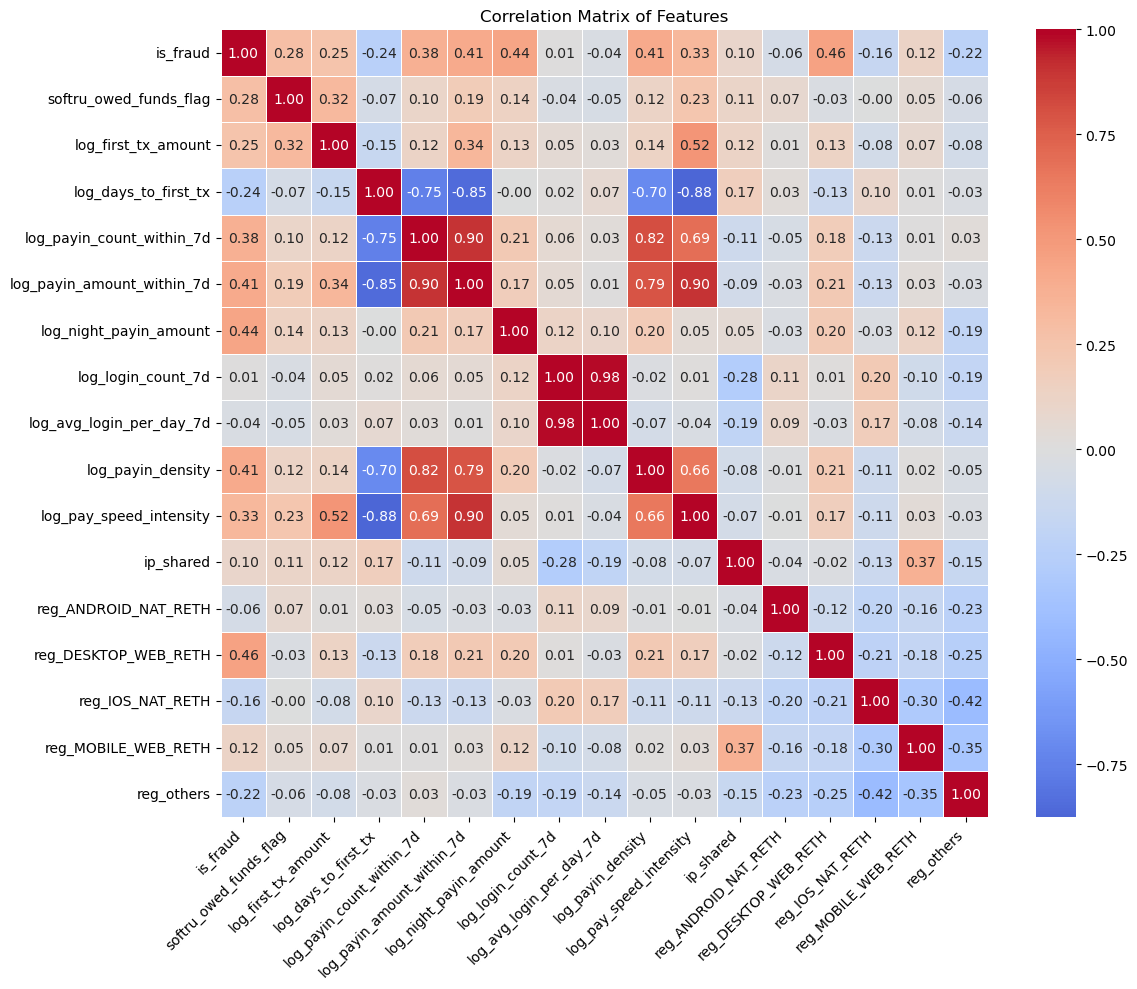

In [48]:
plt.figure(figsize=(12, 10))
sns.heatmap(train_df_1.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Plot ROC curves and compute the AUC:

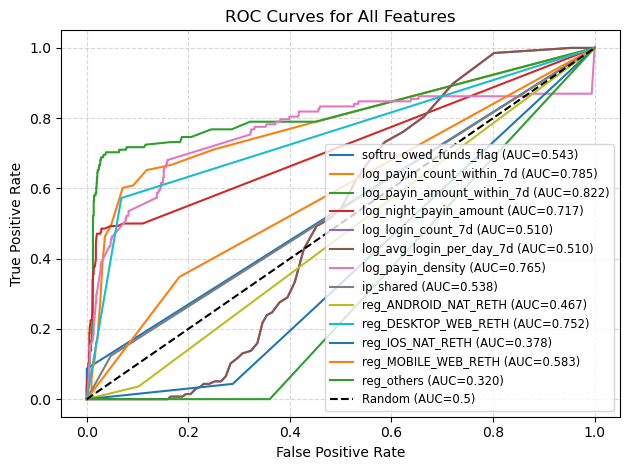

In [49]:
for col in X.columns:
    try:
        fpr, tpr, _ = roc_curve(y, X[col])
        auc = roc_auc_score(y, X[col])
        plt.plot(fpr, tpr, label=f"{col} (AUC={auc:.3f})")
    except ValueError:
        continue 

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Features")
plt.legend(fontsize='small')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Based on correlation and ROC-AUC analysis, we removed weak features with low predictive power.

In [50]:
def drop_weak_features(df):
    """
    Drop weak features based on low correlation and AUC.

    Parameters:
        df (pd.DataFrame): Input DataFrame (train or test)

    Returns:
        pd.DataFrame: DataFrame with weak features removed
    """
    features_to_drop = [
        'log_login_count_7d',
        'log_avg_login_per_day_7d',
        'reg_ANDROID_NAT_RETH',
        'reg_IOS_NAT_RETH',
        'reg_others',
        'log_days_to_first_tx'
    ]
    return df.drop(columns=features_to_drop)

In [51]:
train_df_cleaned = drop_weak_features(train_df_1)
test_df_cleaned = drop_weak_features(test_df_1)

## **5. Model Training** 

#### **5.1 Train the Model**

In [52]:
# Prepare training data
X_train = train_df_cleaned.drop(columns=['is_fraud'])
y_train = train_df_cleaned['is_fraud']

X_test = test_df_cleaned.drop(columns=['is_fraud'])
y_test = test_df_cleaned['is_fraud']

# Initialize and train model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    scale_pos_weight=10.13 # to mitigate the problem of extreme imbalance of target variables
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       601
           1       0.82      0.86      0.84        59

    accuracy                           0.97       660
   macro avg       0.90      0.92      0.91       660
weighted avg       0.97      0.97      0.97       660

AUC: 0.9852646718745594


##### Perform 5-fold validation:

Mean AUC: 0.986


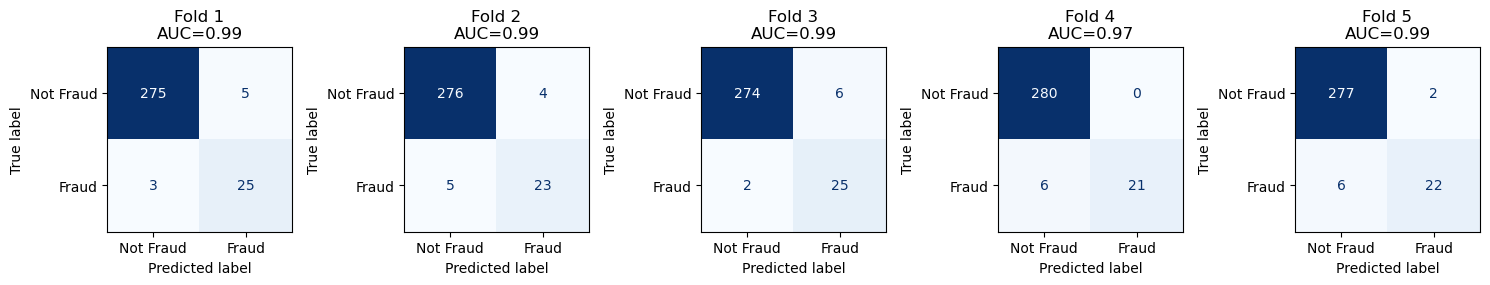

In [53]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = XGBClassifier(eval_metric='logloss', random_state=42)

auc_list = []
plt.figure(figsize=(15, 3))

for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    y_pred = model.predict(X_train.iloc[val_idx])
    y_prob = model.predict_proba(X_train.iloc[val_idx])[:, 1]

    auc = roc_auc_score(y_train.iloc[val_idx], y_prob)
    auc_list.append(auc)

    cm = confusion_matrix(y_train.iloc[val_idx], y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Not Fraud', 'Fraud'])
    plt.subplot(1, 5, i)
    disp.plot(ax=plt.gca(), cmap='Blues', colorbar=False)
    plt.title(f'Fold {i}\nAUC={auc:.2f}')

plt.tight_layout()
print(f'Mean AUC: {np.mean(auc_list):.3f}')

#### **5.2 Explainability Analysis**

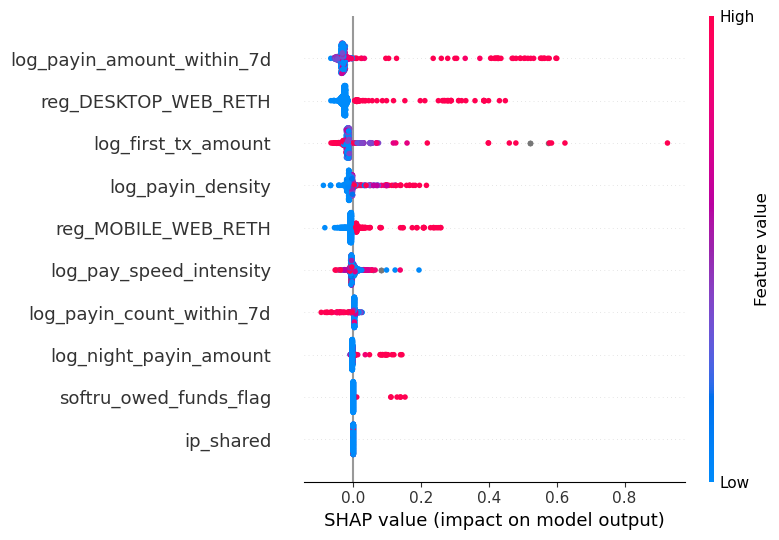

In [54]:
# Create explainer
explainer = shap.Explainer(model, X_train, model_output="probability")
#explainer = shap.Explainer(model, X_train, feature_names=X_train.columns, link="logit")
shap_values = explainer(X_test)

# Summary plot: global feature importance
shap.summary_plot(shap_values, X_test)

In [55]:
# Find the first fraud sample
fraud_pos = np.where(y_test.values == 1)[0][0]  # get first match in array

# Visualize SHAP force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,                  # base value (in probability)
    shap_values.values[fraud_pos],             # extract raw SHAP values
    X_test.iloc[fraud_pos]                     # original feature values
)